In [27]:
# =======================
# SETUP- Gerekli Kutuphanelerin Kurulumu ve Ice Aktarilmasi
# =======================

# ultralytics: YOLOv8 modelini kullanmak icin gerekli kutuphane
# easyocr: Plaka uzerindeki metni okumak icin OCR (Optical Character Recognition) kutuphanesi
!pip install ultralytics easyocr

# kagglehub: Kaggle'dan veri setini indirmek icin kullanilir
# os, shutil: Dosya ve dizin islemleri icin sistem kutuphaneleri
# torch: PyTorch, derin ogrenme framework'u (GPU kontrolu icin kullanilacak)
# cv2: OpenCV, goruntu isleme kutuphanesi
# easyocr: OCR islemleri icin
# re: Duzenli ifadeler (regex) ile metin isleme
import kagglehub, os, shutil, torch, cv2, easyocr, re
from ultralytics import YOLO
from IPython.display import Image as IPImage, display

In [28]:
# =======================
# DATASET- Veri Setinin Indirilmesi ve Hazirlanmasi
# =======================

# Kaggle'dan Turk plaka veri setini indir
dataset = kagglehub.dataset_download('smaildurcan/turkish-license-plate-dataset')

# Veri setini yazilabilir bir dizine kopyalayacagiz (/content/plaka_data_writable)
dst = '/content/plaka_data_writable'

# Eger hedef dizin zaten varsa, icerigini temizle (onceki calistirmalardan kalan verileri sil)
if os.path.exists(dst):
    shutil.rmtree(dst)

# Veri setini hedef dizine kopyala
shutil.copytree(dataset, dst)

# YOLO etiket formati 'labels' klasoru bekler, veri setinde 'label' varsa adini degistir
if os.path.exists(f'{dst}/label'):
    os.rename(f'{dst}/label', f'{dst}/labels')

# YOLO egitimi icin gerekli yapilandirma dosyasini olustur (plaka_data.yaml)
# Bu dosya veri setinin konumunu ve sinif bilgilerini icerir
with open('plaka_data.yaml','w') as f:
    f.write(
        "path: /content/plaka_data_writable/\n"
        "train: images\nval: images\n"
        "nc: 1\nnames: ['license_plate']\n"
    )

print("Dataset hazır.")

Using Colab cache for faster access to the 'turkish-license-plate-dataset' dataset.
Dataset hazır.


In [29]:
# =======================
# TRAIN- Model Egitimi
# =======================

# GPU kullanilabilirligini kontrol et ve ekrana yazdir
# Egitim GPU'da cok daha hizli olacaktir
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "YOK")

# YOLOv8 small (yolov8s) on egitimli modelini yukle
# Bu model COCO veri setinde egitilmis genel bir nesne tespit modeli
model = YOLO('yolov8s.pt')

# Modeli Turk plaka veri setinde egit
model.train(
    data='plaka_data.yaml',
    epochs=1,
    imgsz=640,
    batch=16,
    name='turkish_lp_detector_final_v3'
)

GPU: Tesla T4
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=plaka_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=turkish_lp_detector_final_v35, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb920ff15b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [30]:
# =======================
# VALIDATION - Modelin Performansini Degerlendirme
# =======================

# En iyi agirliklarin (best.pt) kaydedildigi yolu belirle
# Model egitimi sirasinda en iyi performansi gosteren agirliklar bu dosyaya kaydedilir
best = '/content/runs/detect/turkish_lp_detector_final_v3/weights/best.pt'

# En iyi agirliklari yukle
detector = YOLO(best)

# Modeli dogrulama veri seti uzerinde test et ve metriklerini hesapla
metrics = detector.val(data='plaka_data.yaml', imgsz=640, batch=16)

# Performans metriklerini ekrana yazdir
print("\n--- METRİKLER ---")
print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")
print(f"Precision: {metrics.box.mp}")
print(f"Recall: {metrics.box.mr}")

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 118.0±63.5 MB/s, size: 3474.7 KB)
val: Scanning /content/plaka_data_writable/labels.cache... 1955 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1955/1955 2.1Mit/s 0.0s
train: /content/plaka_data_writable/images/1.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/105.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/125.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/126.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/13.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/134.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/140.jpg: corrupt JPEG restored and saved
train: /content/plaka_data

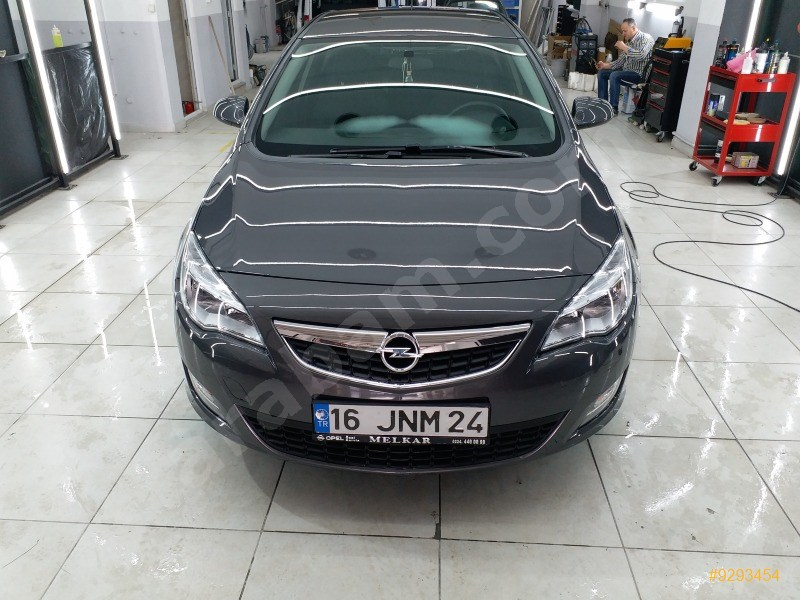


image 1/1 /content/plaka_data_writable/images/1053.jpg: 480x640 1 license_plate, 14.6ms
Speed: 6.6ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
OCR Ham: 16JNM24
✅ Okunan Plaka: 16JNM24


In [31]:
# =======================
# OCR + ÇİZİM - Plaka Tespiti ve Karakter Tanima
# =======================

# Goruntulerin bulundugu dizini belirle
IMG_DIR = f'{dst}/images'

# Dizindeki 62. goruntuyu sec (index 61)
# jpg veya png uzantili dosyalari alfabetik sirala ve birini sec
img_name = sorted([f for f in os.listdir(IMG_DIR) if f.lower().endswith(('jpg','png'))])[61]
img_path = f"{IMG_DIR}/{img_name}"

# Secilen goruntuyu OpenCV ile oku (BGR formatinda)
img = cv2.imread(img_path)

# Orijinal goruntuyu Jupyter'da goster
display(IPImage(filename=img_path))

# YOLO tespiti
# conf=0.4: Guven esigi %40 (bunun uzerindeki tespitler kabul edilir)
res = detector(img_path, conf=0.4)[0]

# Eger hic plaka tespit edilmediyse hata ver
if not res.boxes:
    raise Exception("❌ Plaka bulunamadı")

# Ilk tespit edilen plakanin koordinatlarini al (x1,y1: sol ust kose, x2,y2: sag alt kose)
x1, y1, x2, y2 = map(int, res.boxes.xyxy[0])

# Plaka bolgesini orijinal goruntuден kirp (crop)
plate = img[y1:y2, x1:x2]

# =======================
# OCR - Plaka Uzerindeki Metni Okuma
# =======================

# EasyOCR okuyucusunu baslat (Turkce ve Ingilizce karakterleri taniyacak)
ocr = easyocr.Reader(['tr','en'])

# Plaka goruntusunu gri tonlamaya cevir (OCR icin daha iyi sonuc verir
g = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

# Goruntuyu 2 kat buyut (OCR dogrulagunu artirmak icin)
# INTER_CUBIC: Yuksek kaliteli interpolasyon yontemi
g = cv2.resize(g, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# Otsu esikleme ile ikili (binary) goruntu olustur (arka plan-on plan ayrimi)
# Bu islem metni arka plandan daha net ayirir
_, g = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# OCR ile plaka metnini oku, sadece metni al (koordinat bilgisi istemiyoruz)
raw = "".join(ocr.readtext(g, detail=0))

# Okunan metinden sadece harf ve rakamlari al (bosluk, noktalama vb. temizle)
# Tum karakterleri buyuk harfe cevir
raw = re.sub(r'[^A-Z0-9]', '', raw.upper())

# Eger metin "TR" ile basliyorsa (bazi plakalarda ulke kodu olabilir), bunu kaldir
if raw.startswith("TR"):
    raw = raw[2:]

# Turk plaka formatini yakala: 2 rakam + 1-3 harf + 2-4 rakam
# Ornek: 34ABC1234, 06A1234, 81XYZ999
# Il kodlari 01-81 arasi (sadece 82 ve uzeri gecersiz)
m = re.search(r'(0[1-9]|[1-7][0-9]|8[01])[A-Z]{1,3}[0-9]{2,4}', raw)
raw = m.group(0) if m else raw

# OCR hata duzeltme sozlugu
# OCR bazen rakamlari harf olarak (veya tersini) okuyabilir, en yaygin hatalari duzelt
fix = {'Z':'7','O':'0','A':'4','S':'5','B':'8'}

# Akilli duzeltme fonksiyonu
# Ilk 2 karakter (il kodu) ve 3-5. karakterler (harfler) degistirilmez
# 6. karakterden sonraki karakterler (rakamlar) duzeltme sozlugune gore duzeltilir
def smart(text):
    return (
        text[:2] +
        text[2:5] +
        "".join(fix.get(c, c) for c in text[5:])
    )

# Akilli duzeltmeyi uygula
plate_text = smart(raw)

# Sonuclari ekrana yazdir
print("OCR Ham:", raw) # Duzeltme oncesi ham OCR ciktisi
print("✅ Okunan Plaka:", plate_text) # Duzeltme sonrasi nihai plaka metni

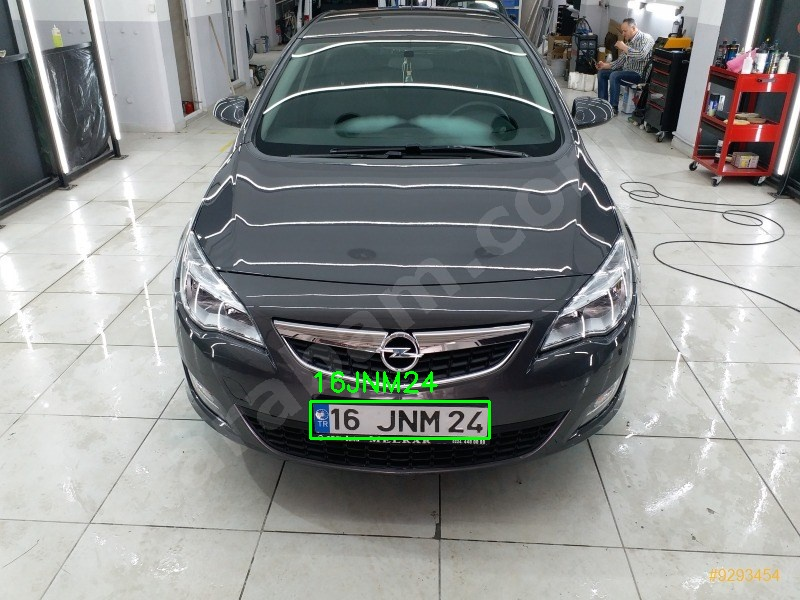

In [32]:
# =======================
# GÖRSEL ÜZERİNE ÇİZİM - Sonuclari Gorsellestirme
# =======================

# Orijinal goruntunun bir kopyasini olustur (uzerine cizim yapacagiz)
draw = img.copy()

# Tespit edilen plaka etrafina yesil dikdortgen ciz
# (x1,y1): Sol ust kose, (x2,y2): Sag alt kose
# (0,255,0): Yesil renk (BGR formatinda), 2: Cizgi kalinligi
cv2.rectangle(draw, (x1, y1), (x2, y2), (0,255,0), 2)

# Okunan plaka metnini dikdortgenin ustune yaz
cv2.putText(
    draw,  # Uzerine yazilacak goruntu
    plate_text,  # Yazilacak metin (okunan plaka)
    (x1, y1-10), # Metin pozisyonu (dikdortgenin hemen ustu)
    cv2.FONT_HERSHEY_SIMPLEX, # Font tipi
    0.9, # Font boyutu
    (0,255,0), # Metin rengi (yesil)
    2 # Metin kalinligi
)

# Sonuc goruntusunu Jupyter'da goster
# OpenCV goruntusunu JPEG formatina kodla ve goster
display(IPImage(data=cv2.imencode('.jpg', draw)[1].tobytes()))